# Second Order Extended Kalman Filter

Wouter Kouw, last update: 05-07-2023


In [1]:
# using Pkg
# Pkg.activate("..")
# Pkg.instantiate()

In [2]:
using Revise
using Optim
using ForwardDiff
using ProgressMeter
using LinearAlgebra
using Distributions
using Plots
default(label="", grid=false, linewidth=3, markersize=3, margin=10Plots.pt)
include("../util.jl")

e (generic function with 1 method)

## 1D state - 1D sensor

In [3]:
# Grid over state space
N = 500
states = range(0, stop=2π, length=N)

# State covariance
S_t = 1.0

# Observation noise
R = 1e-2

0.01

In [4]:
# Observation function
g(z) = sin(z)

# Derivatives
J(z) = ForwardDiff.derivative(g, z)
H(z) = ForwardDiff.derivative(J, z)

# Curvature
κ(z) = abs(H(z))/(1+ J(z)^2)^(3/2)

κ (generic function with 1 method)

In [5]:
ambET1 = zeros(N)    
for (i,m_t) in enumerate(states)

    # Unscented transform moments
    mE, SE, CE = ET1(m_t, S_t, g, addmatrix=R)

    # Calculate ambiguity
    ambET1[i] = log(max(1e-8,SE-CE'*inv(S_t)*CE))
    
end

In [6]:
ambET2 = zeros(N)    
for (i,m_t) in enumerate(states)

    # Unscented transform moments
    mE, SE, CE = ET2(m_t, S_t, g, addmatrix=R)

    # Calculate ambiguity
    ambET2[i] = log(max(1e-8,SE-CE'*inv(S_t)*CE))
    
end

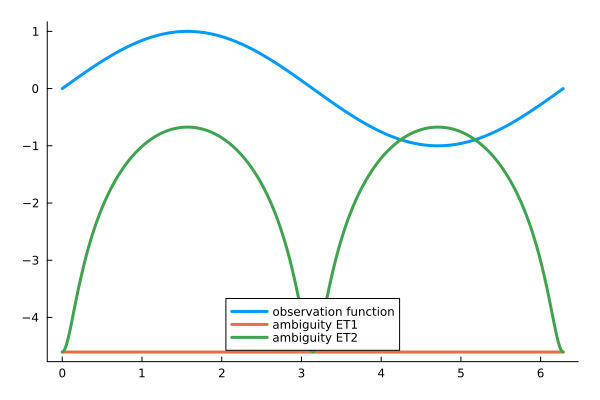

In [7]:
plot(states, g.(states), label="observation function")
plot!(states, ambET1, label="ambiguity ET1", legend=:bottom)
plot!(states, ambET2, label="ambiguity ET2", legend=:bottom)

## 2D states - 1D sensor

In [8]:
m = randn(2)
S = diagm(rand(2))

2×2 Matrix{Float64}:
 0.765475  0.0
 0.0       0.626731

In [9]:
g(x::AbstractVector) = cos(x[1]) + sin(x[2])
Jm = ForwardDiff.gradient(g, m)

2-element Vector{Float64}:
 -0.17476095982157933
  0.4064830224997962

In [10]:
# Dimensionalities
N = length(g(m))
M = length(m)

Jm = ForwardDiff.gradient(g, m)

2-element Vector{Float64}:
 -0.17476095982157933
  0.4064830224997962

In [11]:
Hm = ForwardDiff.hessian(g, m)
aux1 = tr(Hm*S)

-0.18107728784066712

In [12]:
aux2 = tr(Hm*S*Hm*S)

0.8959473095737067

In [13]:
μ, Σ, Γ = ET2(m,S,g)

(-0.01958608741455886, 0.5749060737578009, [-0.133775149347392, 0.2547554011822823])

In [14]:
# Grid over state space
T = 100
ring = range(0, stop=2π, length=T)
states = [cos.(ring'); sin.(1/2 .*ring')]

g(x::AbstractVector) = atan(x[1],x[2])

# State covariance
S_t = diagm(ones(2))

# Observation noise
R = nothing

ambET2 = zeros(T)    
for k in 1:T

    # Unscented transform moments
    mE, SE, CE = ET2(states[:,k], S_t, g, addmatrix=R)

    # Calculate ambiguity
    ambET2[k] = 1/2*logdet(SE-CE'*inv(S_t)*CE)
    
end

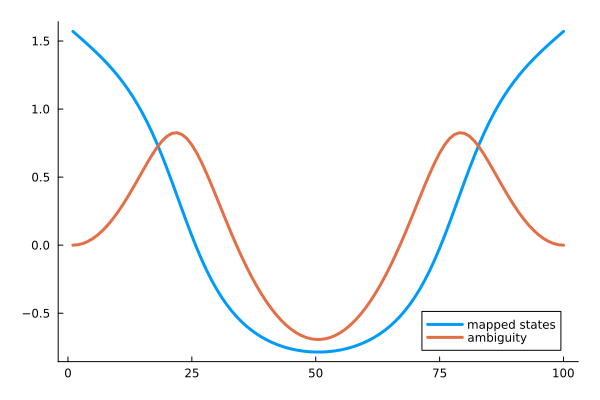

In [15]:
y = cat([g(states[:,i]) for i in 1:T]..., dims=2)
plot(y', label="mapped states")
plot!(ambET2, label="ambiguity")

## 2D states - 2D sensor

### Cartesian to polar

In [16]:
m = randn(2)
S = diagm(rand(2))

2×2 Matrix{Float64}:
 0.469325  0.0
 0.0       0.345918

In [80]:
# Cartesian to polar
g(x::AbstractVector) = [norm(x,2), atan(x[2],x[1])]
Jm = ForwardDiff.jacobian(g, m)

2×2 Matrix{Float64}:
 0.730116  -0.683323
 0.443578   0.473954

In [81]:
# Dimensionalities
N = length(g(m))
M = length(m)

Jm = ForwardDiff.jacobian(g, m)

2×2 Matrix{Float64}:
 0.730116  -0.683323
 0.443578   0.473954

In [82]:
aux1 = zeros(eltype(m), N)
Hi = zeros(eltype(m), M,M,N)
for i in 1:N
    g_i(x) = g(x)[i]
    Hi[:,:,i] = ForwardDiff.hessian(g_i, m)
    aux1 += e(i,N)*tr(Hi[:,:,i]*S)
end
aux1

2-element Vector{Float64}:
  0.26195776039299
 -0.051889392378206056

In [83]:
# Auxiliary terms
aux2 = zeros(eltype(m), N,N)
for i in 1:N
    for j in 1:N
        aux2 += e(i,N)*e(j,N)'*tr(Hi[:,:,i]*S*Hi[:,:,j]*S)
    end
end
aux2

2×2 Matrix{Float64}:
  0.0686219  -0.0135928
 -0.0135928   0.0603497

In [84]:
μ, Σ, Γ = ET2(m,S,g)

([1.6714581014304497, -0.778249354686674], [0.44601344467822257 0.033170850872767; 0.033170850872767 0.2002243667186957], [0.3426619352538055 0.20818256513645028; -0.23637357150263202 0.16394898628938645])

In [90]:
# Grid over state space
T = 100
xr = zeros(T)
yr = range(-1, stop=1, length=T)
states = [xr yr]'

# State covariance
S_t = 1e-3diagm(ones(2))

# Observation noise
R = 1diagm(ones(2))

ambET2 = zeros(T)    
for k in 1:T

    # Unscented transform moments
    mE, SE, CE = ET2(states[:,k], S_t, g, addmatrix=R, forceHermitian=true)

    # Calculate ambiguity
    ambET2[k] = 1/2*logdet(SE-CE'*inv(S_t)*CE)
    
end

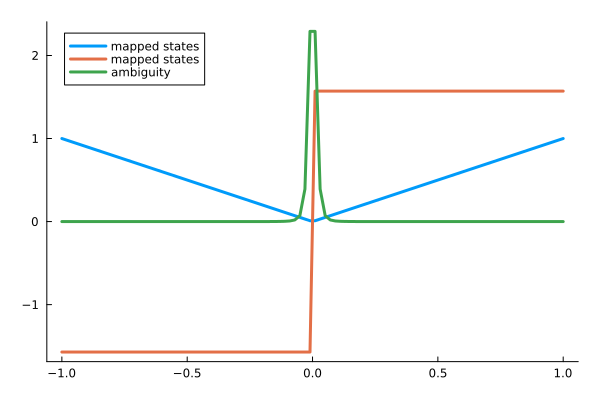

In [91]:
y = cat([g(states[:,i]) for i in 1:T]..., dims=2)
plot(yr, y', label="mapped states")
plot!(yr, ambET2, label="ambiguity")

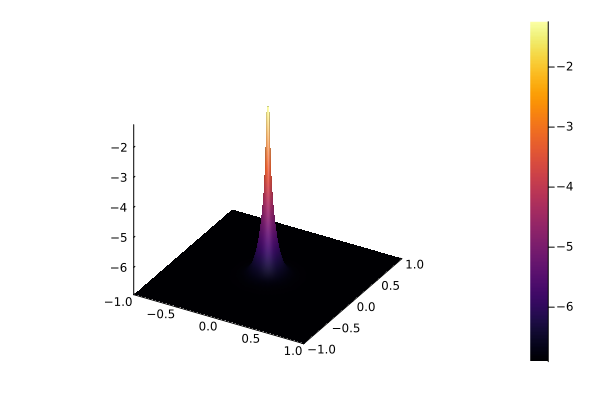

In [92]:
function helper(x,y)

    # Unscented transform moments
    mE, SE, CE = ET2([x; y], S_t, g, addmatrix=1e-3*I(2), forceHermitian=true)

    # Calculate ambiguity
    return 1/2*logdet(SE-CE'*inv(S_t)*CE)

end

xr = range(-1, stop=1, length=T)
yr = range(-1, stop=1, length=T)
# contourf(xr,yr, (xr,yr) -> helper(xr,yr), nlevels=100, xlabel="x1", ylabel="x2")
surface(xr,yr, (xr,yr) -> helper(xr,yr))

### Polar to cartesian

In [24]:
# Polar to Cartesian
g(x::AbstractVector) = [x[1]*cos(x[2]), x[1]*sin(x[2])]
Jm = ForwardDiff.jacobian(g, m)

2×2 Matrix{Float64}:
  0.495275  0.977093
 -0.868736  0.55705

In [25]:
# Dimensionalities
N = length(g(m))
M = length(m)

Jm = ForwardDiff.jacobian(g, m)

2×2 Matrix{Float64}:
  0.495275  0.977093
 -0.868736  0.55705

In [26]:
aux1 = zeros(eltype(m), N)
Hi = zeros(eltype(m), M,M,N)
for i in 1:N
    g_i(x) = g(x)[i]
    Hi[:,:,i] = ForwardDiff.hessian(g_i, m)
    aux1 += e(i,N)*tr(Hi[:,:,i]*S)
end
aux1

2-element Vector{Float64}:
 -0.1926933009529889
  0.3379935709942034

In [27]:
# Auxiliary terms
aux2 = zeros(eltype(m), N,N)
for i in 1:N
    for j in 1:N
        aux2 += e(i,N)*e(j,N)'*tr(Hi[:,:,i]*S*Hi[:,:,j]*S)
    end
end
aux2

2×2 Matrix{Float64}:
 0.28218    0.0745756
 0.0745756  0.193887

In [28]:
μ, Σ, Γ = ET2(m,S,g)

([0.4607029813343872, -0.8080957929454685], [0.5864649517286282 0.02363355646413029; 0.023633556464130262 0.5584842378642831], [0.23244499492856088 -0.4077200063888115; 0.3379935709942034 0.1926933009529889])

In [38]:
# Grid over state space
T = 100
states = transpose([range(0, stop=1., length=T) range(0, stop=2π, length=T)])

# State covariance
S_t = diagm(ones(2))

# Observation noise
R = nothing

ambET2 = zeros(T)    
for k in 1:T

    # Unscented transform moments
    mE, SE, CE = ET2(states[:,k], S_t, g, addmatrix=R, forceHermitian=true)

    # Calculate ambiguity
    ambET2[k] = 1/2*logdet(SE-CE'*inv(S_t)*CE)
    
end

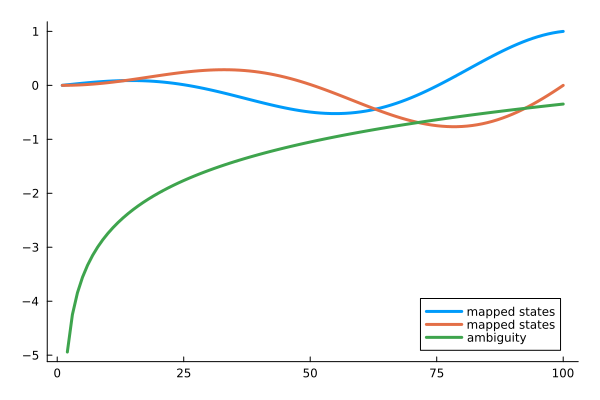

In [39]:
y = cat([g(states[:,i]) for i in 1:T]..., dims=2)
plot(y', label="mapped states")
plot!(ambET2, label="ambiguity")

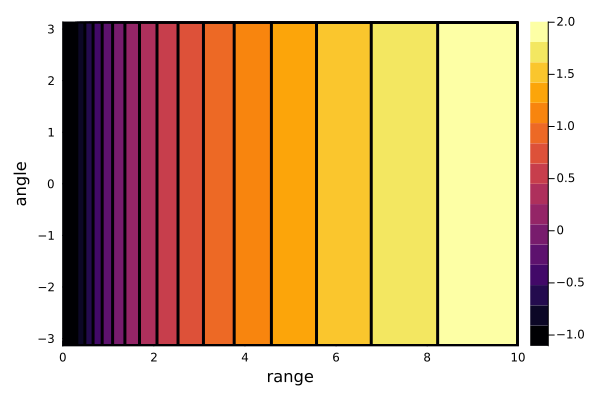

In [33]:
function helper(x,y)

    # Unscented transform moments
    mE, SE, CE = ET2([x; y], S_t, g, addmatrix=0.1*I(2), forceHermitian=true)

    # Calculate ambiguity
    return 1/2*logdet(SE-CE'*inv(S_t)*CE)

end

x1 = range(0,stop=10, length=100)
x2 = range(-π,stop=π, length=100)
contourf(x1,x2, (x1,x2) -> helper(x1,x2), xlabel="range", ylabel="angle")

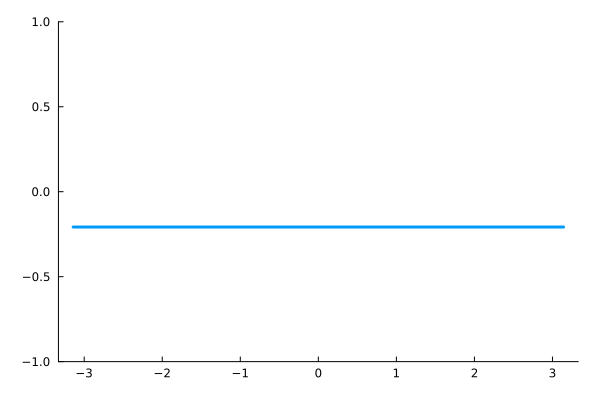

In [36]:
plot(x2, helper.(1., x2), ylims=[-1., 1.])